In [3]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Subset, DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [5]:
transform = T.Compose([ T.ToTensor(),
                        T.Normalize(.5, .5)])
train = torchvision.datasets.FashionMNIST('./data', train = True, download = True, transform = transform)
dev_test = torchvision.datasets.FashionMNIST('./data', train = False, download = True, transform = transform)


100%|██████████| 26421880/26421880 [00:00<00:00, 120015548.08it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 10060534.95it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




100%|██████████| 4422102/4422102 [00:00<00:00, 68507202.88it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 7889030.69it/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [6]:
randidx = np.random.permutation(10000)
devset = Subset(dev_test, randidx[:6000])
testset = Subset(dev_test, randidx[6000:])

batchsize = 32
train_loader = DataLoader(train, batch_size = batchsize, shuffle = True)
dev_loader = DataLoader(devset, batch_size = len(devset))
test_loader = DataLoader(testset, batch_size = len(testset))

In [7]:
# check out the shape of the datasets
print('Data shapes (train/dev/test):')
print( len(train) )
print( len(devset) )
print( len(testset) )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(train.data),torch.max(train.data)) )

# the unique categories
print('\nData categories:')
print( train.classes )

Data shapes (train/dev/test):
60000
6000
4000

Data value range:
(tensor(0, dtype=torch.uint8), tensor(255, dtype=torch.uint8))

Data categories:
['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [8]:
# Uh oh! It looks like the images are the wrong dimensions!
# They need to be 1x28x328
# And they are not normalized!

# but...
X,y = next(iter(test_loader))

# try again
print('Data shapes (train/test):')
print( X.data.shape )

# and the range of pixel intensity values
print('\nData value range:')
print( (torch.min(X.data),torch.max(X.data)) )

Data shapes (train/test):
torch.Size([4000, 1, 28, 28])

Data value range:
(tensor(-1.), tensor(1.))


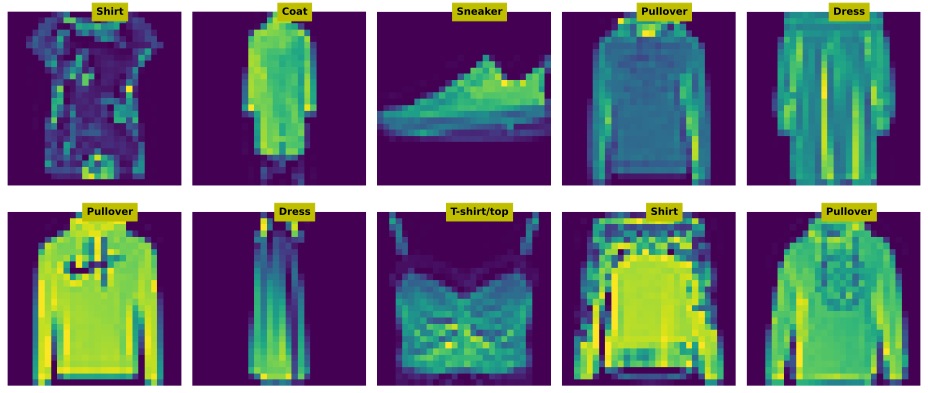

In [9]:
fig, axs = plt.subplots(2, 5, figsize = (13, 6))
for (i, ax) in enumerate(axs.flatten()):
    randidx = np.random.choice(batchsize)
    img = X[i,:,:]
    label = train.classes[y[i]]
    ax.imshow(np.squeeze(img))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')
    ax.text(16, 0, label, ha = 'center', fontweight = 'bold', color = 'k', backgroundcolor = 'y')

plt.tight_layout()
plt.show()




In [92]:


def makeTheNet():

    class fmnistnet(nn.Module):

        def __init__(self):
            super().__init__()

            # conv BLOCK 1
            self.conv1 = nn.Conv2d(1, 16, 5, padding = 2)
            self.conv2 = nn.Conv2d(16, 16, 3, padding = 1)
            self.bn1 = nn.BatchNorm2d(16)

            # img size = (14, 14)
            # conv BLOCK 2
            self.conv3 = nn.Conv2d(16, 32, 3, padding = 1)
            self.bn2 = nn.BatchNorm2d(32)

            # img size = (7, 7)
            # conv BLOCK 3
            self.conv4 = nn.Conv2d(32, 64, 3,padding = 1)
            self.bn3 = nn.BatchNorm2d(64)

            # linear layers
            self.fc1 = nn.Linear(64*3*3, 128)
            self.fc2 = nn.Linear(128, 10)



        def forward(self, x):

            x = F.max_pool2d(self.conv2(self.conv1(x)), 2)
            x = F.leaky_relu(self.bn1(x))

            x = F.max_pool2d(self.conv3(x), 2)
            x = F.leaky_relu(self.bn2(x))

            x =  F.max_pool2d(self.conv4(x), 2)
            # x = F.leaky_relu(self.bn3(x))
            x =F.leaky_relu(self.bn3(x))

            nUnits = (x.shape.numel()/x.shape[0])
            x = x.view(-1, int(nUnits))

            x = F.relu(self.fc1(x))
            x = F.dropout(x, p = 0.5, training = self.training)
            x = F.relu(self.fc2(x))


            return x

    net = fmnistnet()
    net.to(device)

    lossfun = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr = .001)

    return net, lossfun, optimizer





In [93]:

net, lossfun, optimzier = makeTheNet()
net.cpu()
X, y = next(iter(train_loader))
yHat = net(X)

# check size of output
print('\nOutput size:')
print(yHat.shape)

# now lets compute the loss
loss = lossfun(yHat, torch.squeeze(y))
print(' ')
print('Loss')
print(loss)


Output size:
torch.Size([32, 10])
 
Loss
tensor(2.3487, grad_fn=<NllLossBackward0>)


In [94]:
from torchsummary import summary

summary(net, (1, 28, 28), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             416
            Conv2d-2           [-1, 16, 28, 28]           2,320
       BatchNorm2d-3           [-1, 16, 14, 14]              32
            Conv2d-4           [-1, 32, 14, 14]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
            Conv2d-6             [-1, 64, 7, 7]          18,496
       BatchNorm2d-7             [-1, 64, 3, 3]             128
            Linear-8                  [-1, 128]          73,856
            Linear-9                   [-1, 10]           1,290
Total params: 101,242
Trainable params: 101,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.30
Params size (MB): 0.39
Estimated Total Size (MB): 0.69
-------------------------------------------

In [95]:
def function2trainTheModel():

    # number of epochs
    numepochs = 25

    # create a new model
    net, lossfun, optimizer = makeTheNet()

    # send the model to the GPu
    net.to(device)

    trainLoss = torch.zeros(numepochs)
    devLoss = torch.zeros(numepochs)
    trainAcc = torch.zeros(numepochs)
    devAcc = torch.zeros(numepochs)

    for epochi in range(numepochs):

        # loop over training data batches
        net.train()
        batchLoss = []
        batchAcc = []

        for X, y in train_loader:

            X = X.to(device)
            y = y.to(device)
            yHat = net(X)
            loss = lossfun(yHat, y)
            batchLoss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batchAcc.append(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()).item())


        trainLoss[epochi] = np.mean(batchLoss)
        trainAcc[epochi] = 100*np.mean(batchAcc)


        # test performance
        net.eval()
        X, y = next(iter(dev_loader))
        X = X.to(device)
        y = y.to(device)

        with torch.inference_mode():
            yHat = net(X)
            loss = lossfun(yHat, y)
            devLoss[epochi] = loss.item()
            devAcc[epochi] = 100*(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()).item())

        if epochi+1 % 5 == 0:
            print(f'Epoch: {epochi+1}/{numepochs}, Train Accuracy: {trainAcc[epochi]}, Devset Accuracy: {devAcc[epochi]}')

    return trainLoss, devLoss, trainAcc, devAcc, net





In [96]:
trainLoss, devLoss, trainAcc, devAcc, net = function2trainTheModel()

Epoch: 1/25, Train Accuracy: 83.38166809082031, Devset Accuracy: 88.53333282470703
Epoch: 6/25, Train Accuracy: 92.25833129882812, Devset Accuracy: 90.66667175292969
Epoch: 11/25, Train Accuracy: 93.96499633789062, Devset Accuracy: 91.98333740234375
Epoch: 16/25, Train Accuracy: 95.10166931152344, Devset Accuracy: 91.66667175292969
Epoch: 21/25, Train Accuracy: 95.9000015258789, Devset Accuracy: 91.56666564941406


In [98]:
net.eval()
X, y = next(iter(test_loader))
X = X.to(device)
y = y.to(device)

with torch.inference_mode():
    yHat = net(X)
    loss = lossfun(yHat, y)
    testLoss = loss.item()
    testAcc = 100*(torch.mean((torch.argmax(yHat.cpu(), axis = 1) == y.cpu()).float()).item())

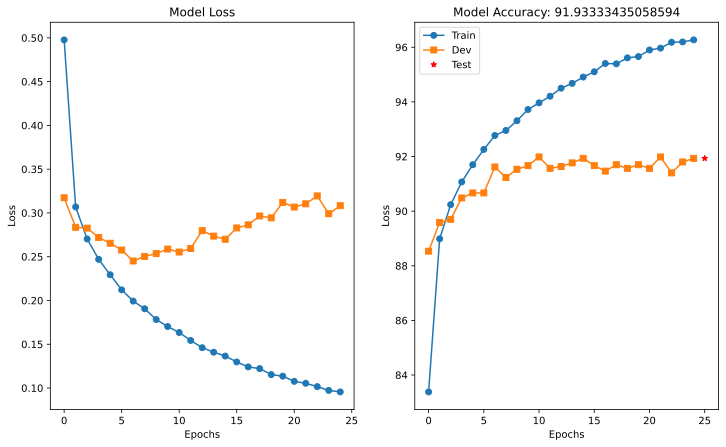

In [101]:
fig, ax = plt.subplots(1,2 , figsize = (12, 7))

ax[0].plot(trainLoss, 'o-', label = 'Train')
ax[0].plot(devLoss, 's-', label = 'Dev')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title(f'Model Loss')

ax[1].plot(trainAcc, 'o-', label = 'Train')
ax[1].plot(devAcc, 's-', label = 'Dev')
ax[1].plot(25, testAcc, 'r*', label = 'Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].set_title(f'Model Accuracy: {devAcc[-1]}')

plt.legend()
plt.show()